### SISTEMA DE RECOMENDACIÓN POR FILTRO COLABORATIVO

El presente trabajo tiene por objetivo contrastar los resultados obtenidos en el sistema de recomendación creado en el sprint 3, para el cual se utilizó el método SVD, con los resultantes del sistema de recomendación por filtro colaborativo a desarrollar en el presente notebook. La hipotesis de trabajo es que si bien las metodologías no son analogas, se deberían obtener similares recomendaciones dado que los inputs de los sistemas son iguales. 

A continuación importamos las librerías necesarias para llevar a cabo el trabajo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
import gc
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from scipy import stats
import pandas as pd
import gzip
from sklearn.preprocessing import OneHotEncoder


Levantamos las bases de datos

In [2]:
data_reviews=pd.read_csv('C:\\Users\\Usuario\\source\\repos\\data_reviews22.csv')
data_reviews.drop('Unnamed: 0',axis=1,inplace=True)

In [3]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [4]:
data_games = []
for l in parse('C:\\Users\\Usuario\\source\\repos\\steam_games.json.gz'):
        data_games.append(l)

In [5]:
data_games = pd.DataFrame(data_games)

### DESCRIPCIÓN DE FEATURES INCLUIDOS EN DATA_REVIEWS

**username:** Nombre del usuario que ha dejado la reseña

**hours:** Cantidad de horas jugadas (acumuladas) en el juego al cual se le ha hecho la reseña

**products:** Cantidad de otros juegos probados

**product_id:** Identificacion númerica del juego reseñado

**page:** Número de página en el cual se encuentra el juego dentro de la plataforma

**date:** Fecha en la cual se ha creado la reseña

**text:** Comentario sobre el juego

**early_access:** Si es True significa que el juego puede ser adquirido durante su etapa de desarrollo

**page_order:** Ubicación del juego dentro de una página

**user_id:** Identificacion númerica del usuario creador de la reseña

**found_funny:** Cantidad de calificaciones positivas creadas por otros usuarios

**compensation:** Variable no interpretable dada la cantidad de valores nulos contenidos en ella

### ANALISIS EXPLORATORIO DATA_REVIEWS

In [6]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,MR_SERENITY,14.8,147.0,35140,2,2018-01-03,aweosme game great story and some epic moments...,False,1,NaN,NaN,7.656120e+16
1,Duha Nubie,11.3,73.0,35140,4,2018-01-03,first debut feel sweet,False,1,NaN,NaN,NaN
2,The Undead StalkeR,17.0,87.0,35140,5,2018-01-03,9/10\nEven after all these years. this game re...,False,1,NaN,NaN,7.656120e+16
3,Mono,14.1,54.0,506510,1,2017-12-27,A Charming game with colourful pixel graphics ...,False,1,NaN,NaN,7.656120e+16
4,Uncle-Noob,24.7,37.0,350280,3,2018-01-04,"I really like this game, but no one plays it. ...",False,1,NaN,NaN,NaN


In [7]:
data_reviews.shape

(2227331, 12)

In [8]:
data_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227331 entries, 0 to 2227330
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   username      object 
 1   hours         float64
 2   products      float64
 3   product_id    int64  
 4   page_order    int64  
 5   date          object 
 6   text          object 
 7   early_access  bool   
 8   page          int64  
 9   found_funny   float64
 10  compensation  object 
 11  user_id       float64
dtypes: bool(1), float64(4), int64(3), object(4)
memory usage: 189.0+ MB


In [9]:
data_reviews.isna().sum()

username              0
hours                 0
products              0
product_id            0
page_order            0
date                  0
text                  0
early_access          0
page                  0
found_funny     1926643
compensation    2196894
user_id         1249261
dtype: int64

In [10]:
data_reviews.drop(['user_id','compensation','found_funny'],axis=1,inplace=True)

In [11]:
data_reviews.describe().applymap('{:,.2f}'.format)

,hours,products,product_id,page_order,page
count,"2,227,331.00","2,227,331.00","2,227,331.00","2,227,331.00","2,227,331.00"
mean,35.44,116.35,"243,937.42",4.49,854.24
std,23.24,73.22,"142,640.35",2.87,"1,548.13"
min,10.10,21.00,10.00,0.00,1.00
25%,16.60,55.00,"203,140.00",2.00,90.00
50%,27.60,99.00,"244,930.00",4.00,322.00
75%,48.90,166.00,"330,830.00",7.00,903.00
max,99.90,299.00,"773,900.00",9.00,"18,370.00"


**Respondemos algunas preguntas:**

*¿Cual es el promedio de horas jugadas por jugador?*

In [12]:
data_reviews.hours.mean()

35.44001803054945

*¿Cual es el jugador que mas horas jugó a un juego? ¿y el que menos?*

In [13]:
data_reviews.loc[:,['hours','username']].max()

hours              99.9
username    󰀖Mr.Tarunio
dtype: object

In [14]:
data_reviews.loc[:,['hours','username']].min()

hours       10.1
username       !
dtype: object

*¿Que cantidad de juegos, prueban en promedio los usuarios?*

In [15]:
data_reviews.products.mean()

116.34962966887275

*¿Cual es el usuario que más juegos probó? y el que menos?*

In [16]:
data_reviews.loc[:,['username','products']].max()

username    󰀖Mr.Tarunio
products          299.0
dtype: object

In [17]:
data_reviews.loc[:,['username','products']].min()

username       !
products    21.0
dtype: object

*¿Se puede afirmar que, existe una alta correlación entre horasy juegos probados?*

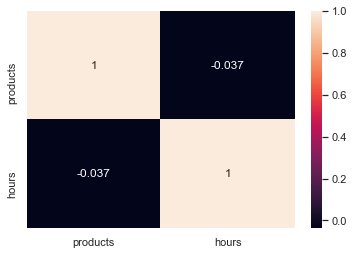

In [18]:
correlacion1=data_reviews.loc[:,['products','hours']].corr()
sns.heatmap(correlacion1,cbar=True,annot=True)

Claramente no se puede afirmar que a mayor cantidad de productos probados, mayor cantidad de horas jugadas. La explicación radica en que la variable 'hours' hace referencia a las horas destinadas por el usuario al juego en el cual dejó su review, por ende, tiene sentido que cuantas mas horas haya dedicado al juego en el cual dejó su reseña menos horas haya podido destinar a otros juegos y de allí que existe una correlación negativa entre ambas variables

*¿La página en la cual se ubica el juego dentro de la plataforma, tiene alguna injerencia para los usuarios?* *¿y la ubicación dentro de la página?*

In [19]:
data_reviews.page.value_counts()

1        15507
2        14248
3        13112
4        12262
5        11834
         ...  
7826         1
15316        1
15317        1
11210        1
11103        1
Name: page, Length: 15900, dtype: int64

In [20]:
min_page=data_reviews.page.value_counts()[data_reviews.page.value_counts()==1].index.min()

In [21]:
bins=np.arange(1,min_page,100)

In [22]:
intervalo_uno=pd.cut(data_reviews['page'],bins).value_counts().values[0]/pd.cut(data_reviews['page'],bins).value_counts().values.sum()
intervalo_dos=pd.cut(data_reviews['page'],bins).value_counts().values[1]/pd.cut(data_reviews['page'],bins).value_counts().values.sum()


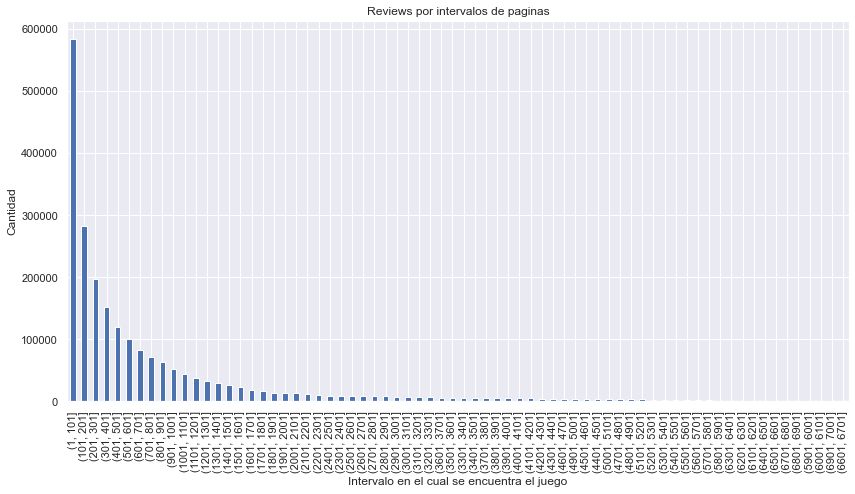

In [23]:

plt.figure(figsize=(14,7))
plt.title('Reviews por intervalos de paginas')
plt.xlabel('Intervalo en el cual se encuentra el juego')
plt.ylabel("Cantidad")
plt.xticks(rotation=90)
page_count=pd.cut(data_reviews['page'],bins).value_counts().plot.bar()

In [24]:
print(f'Del total de los reviews generados por los usuarios el,',intervalo_uno*100,'% corresponde a juegos que se ubican en las primeras 100 páginas y el ',intervalo_dos*100,'%corresponde a juegos ubicados en las 2ndas 100 páginas; por lo que el',intervalo_uno*100+intervalo_dos*100,'% de reviews están comprendidas en las primeras 200 páginas; de un total de 18370 páginas ')

Del total de los reviews generados por los usuarios el, 26.676654380773147 % corresponde a juegos que se ubican en las primeras 100 páginas y el  12.907772643806407 %corresponde a juegos ubicados en las 2ndas 100 páginas; por lo que el 39.584427024579554 % de reviews están comprendidas en las primeras 200 páginas; de un total de 18370 páginas 


In [25]:
min_order=data_reviews.page_order.value_counts()

In [26]:
bins2=np.arange(1,9,1)

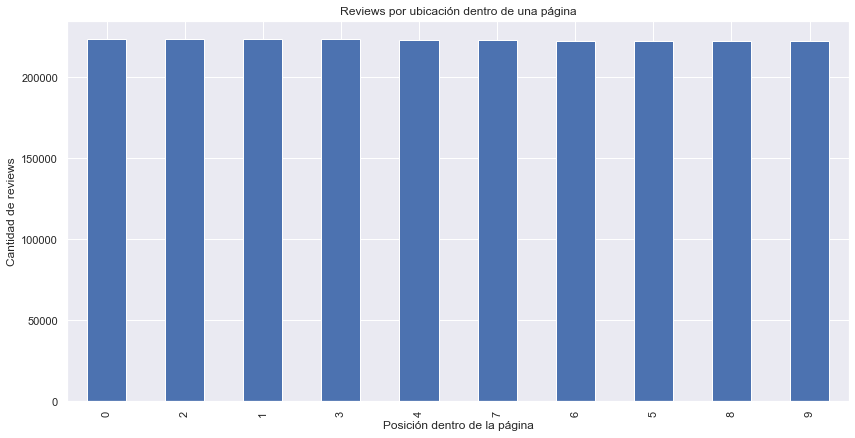

In [27]:
plt.figure(figsize=(14,7))
plt.title('Reviews por ubicación dentro de una página')
plt.xlabel('Posición dentro de la página')
plt.ylabel("Cantidad de reviews")
plt.xticks(rotation=90)
page_count=data_reviews['page_order'].value_counts().plot.bar()


A diferencia de lo que ocurre con la página en la que se ubica el juego, podemos concluir que la ubicación del juego dentro de la página no tiene ninguna injerencia para el usuario calificador. De hecho, puede obervarse en el grafico precedente que las cantidades de reviews es aproximadamente la misma para juegos ubicados en distintos lugares dentro de una pagina

A continuación se observa la proporción de juegos que permiten ser probados antes de su lanzamiento

Text(0.5, 1.0, 'Juegos que permiten ser probados antes de su lanzamiento')

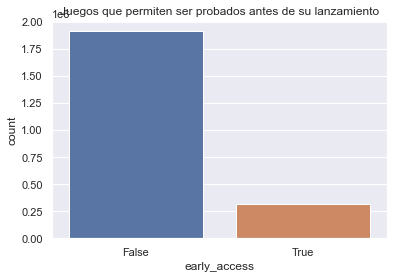

In [28]:
sns.countplot(x=data_reviews.early_access)

plt.title('Juegos que permiten ser probados antes de su lanzamiento')


In [29]:
data_reviews.loc[:,['hours','products','early_access']].groupby(['early_access']).mean()

,hours,products
early_access,,
False,34.948591,118.132822
True,38.435484,105.480278


La cantidad de horas que, en promedio, se destinan a aquellos juegos que pueden ser probados antes de su lanzamiento es muy similar a las horas que se destinan, en promedio, a los que no pueden ser probados antes de su lanzamiento

*A continuación se analiza la variable text por medio de la TextBlob, lo cual permitirá estimar una calificación en función del review dejado por el usuario*

In [30]:
polarity_list=[]
for i in range(len(data_reviews.text)):
    frase=TextBlob(data_reviews.text[i])
    polarity=frase.sentiment.polarity
    polarity_list.append(polarity)

In [31]:
data_reviews['Polarity']=pd.Series(polarity_list)

### CHECKPOINT

In [32]:
data_reviews.to_csv('C:\\Users\\Usuario\\source\\data_reviews2.csv')

In [33]:
del data_reviews

In [34]:
data_reviews2=pd.read_csv('C:\\Users\\Usuario\\source\\data_reviews2.csv')
data_reviews2.drop('Unnamed: 0',inplace=True,axis=1)

In [35]:
data_reviews2.loc[:,['Polarity']].describe().applymap('{:,.2f}'.format)

,Polarity
count,"2,227,331.00"
mean,0.12
std,0.27
min,-1.00
25%,0.00
50%,0.10
75%,0.25
max,1.00


In [36]:
rev_neg=data_reviews2[data_reviews2.Polarity<0].shape[0]/data_reviews2.shape[0]
print(f'El',rev_neg * 100,'% de las reviews tienen un polarity menor a 0, por lo que se entiende como reviews negativas')

El 22.6271712646212 % de las reviews tienen un polarity menor a 0, por lo que se entiende como reviews negativas


In [37]:
rev_pos=data_reviews2[data_reviews2.Polarity>0].shape[0]/data_reviews2.shape[0]
print(f'El',rev_pos * 100,'% de las reviews tienen un polarity mayor a 0, por lo que se entiende como reviews positivas')

El 65.75443883284522 % de las reviews tienen un polarity mayor a 0, por lo que se entiende como reviews positivas


La cantidad de reviews entendidas como positivas en función del polarity arrojado, son sensiblemente superiores a la cantidad de reviews cuyo polarity es menor a 0 y, por ende, negativas. Esto explica de alguna forma que el promedio de Polarity sea 0.1235. Sin embargo, se puede interpretar que un polarity cercano a 0 significa una valoración "indiferente" por parte del usuario.*¿Cómo es la distribución de la variable Polarity?*

([<matplotlib.axis.XTick at 0x1dccb7351c0>,
 <a list of 20 Text major ticklabel objects>)

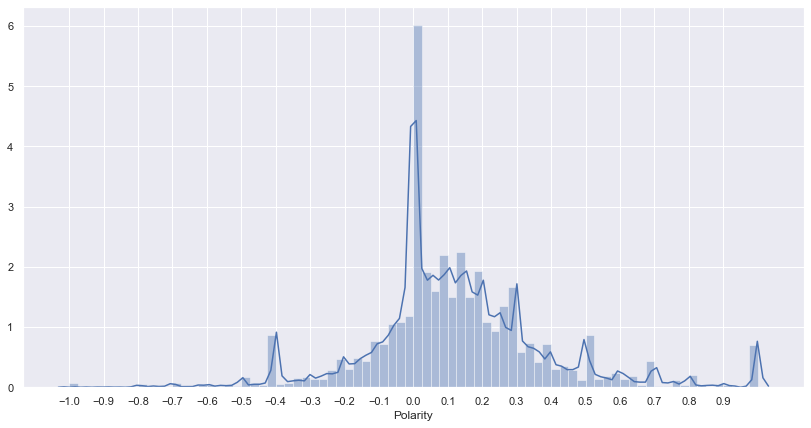

In [38]:
plt.figure(figsize=(14,7))
sns.distplot(data_reviews2.Polarity,bins=80)
plt.xticks(np.arange(-1,1,0.1))

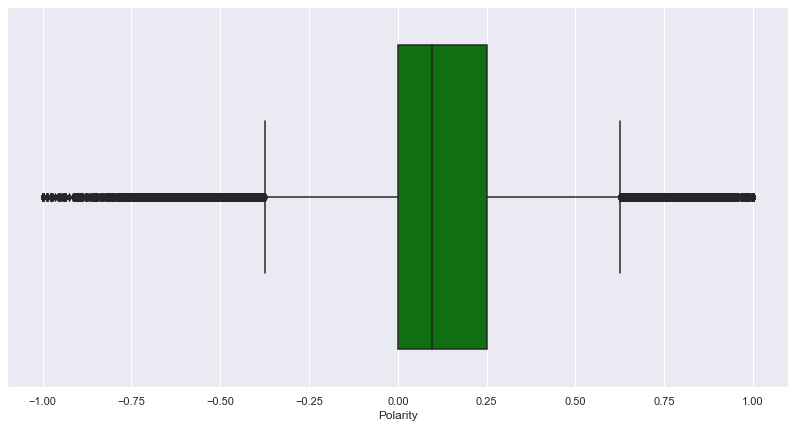

In [39]:
plt.figure(figsize=(14,7))
sns.boxplot(x=data_reviews2.Polarity,color='green')

La última pregunta formulada puede responderse observando los graficos aquí presentados. 
Por un lado, el histograma muestra una distribución de los datos asimilable a una normal, en donde la mayor parte de la información se encuentra contenida en un valor muy cerano a 0. La curva que marca la tendencia del histograma hacia sus extremos, tiene una pendiente negativa hacia ambos lados pero, menos pronunciada hacía el lado positivo. Esto signfica que hay una mayor cantidad de datos entre 0 y 0.4 que entre 0 y -0.4.Cabe destacar que en ambos extremos de la curva de tendencia, se exhibe una acumulación de valores pero, el extremo positivo es mayor que el negativo y esto influye en el promedio general de polaridad.
El mismo comportamiento puede observarse en el gráfico de cajas; se observa que el 50% de los datos se encuentra acumulado entre 0 y 0.25, con una mediana mas cercana al valor 0. Los bigotes del grafico de cajas tiene una longitud similar, indicando que aproximadamente la misma cantidad de datos es contenida en ellos. Por último, los valores considerados Outlier se encuentran desde 0.6 e inferiores a -0.4

### ANALISIS EXPLORATORIO DATA_GAMES

In [40]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [41]:
data_games.shape

(32135, 16)

In [42]:
data_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB


In [43]:
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

In [44]:
data_games.drop_duplicates(subset ="id",keep = False, inplace = True)
data_games.reset_index(inplace=True,drop=True)

Se crea la variable URL_NAME que reemplazará a la variable title pero sin valores nulos

In [45]:
url_splited = data_games.url.str.split('/')

In [46]:
resultados = []
data_games["URL_NAME"] = ""
k=0
m = 5
for i in url_splited:
    data_games["URL_NAME"][k] = i[m]
    resultados.append(i[m])
    k=k+1
k=0

<ipython-input-46-abade9795606>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_games["URL_NAME"][k] = i[m]


In [47]:
data_games.drop(['title'],inplace=True,axis=1)

Se limpian los valores contenidos en la variable price

In [53]:
data_games['precio']=data_games.price

In [84]:
k=0
for y in data_games.precio:
    if(isinstance(y, str)):
        float(y)
        if (y.find('Free')!=-1):
            data_games.precio[k]=y.split(' ')[-1]
            data_games.precio[k]= data_games.precio[k].replace("$", "")
        else:
            data_games.precio[k]=0.00
    k=k+1
    


ValueError: could not convert string to float: 'Free To Play'

In [54]:
max_price=data_games[data_games.precio.notnull()].precio.max()

TypeError: '>=' not supported between instances of 'float' and 'str'

In [51]:
bins2=np.arange(0,max_price,10)

NameError: name 'max_price' is not defined

In [ ]:
price_interval=pd.cut(data_games.precio.notnull(),bins2).value_counts()
price_interval

In [ ]:
pd.cut(data_games['precio'],bins2).value_counts()

### Creamos un nuevo modelo utilizando la libreria LightFM

In [ ]:
!pip install lightfm

In [63]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

C:\Users\Usuario\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [67]:
# Function to create an interaction matrix dataframe from transactional type interactions
data_reviews2 = data_reviews2.head(10000)
#data_reviews2 = data_reviews 
interactions = data_reviews2.groupby(['username', 'product_id'])['Polarity'].sum().unstack().reset_index().fillna(0).set_index('username')

In [68]:
interactions.shape

(9599, 150)

In [69]:
len(data_reviews2.product_id.unique())

150

In [75]:
# Function to create a user dictionary based on their index and number in interaction dataset
username = list(interactions.index)
userdict = {}
counter = 0 
for i in username:
    userdict[i] = counter
    counter += 1

# Function to create an item dictionary based on their item_id and item name
games = data_games.reset_index()
item_dict ={}
for i in range(games.shape[0]):
    item_dict[(games.loc[i,'id'])] = games.loc[i,'URL_NAME']

In [78]:
from scipy import sparse

In [79]:
x = sparse.csr_matrix(interactions.values)

In [80]:
interactions.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Benchmark

In [81]:
model = LightFM(no_components= 300, loss='warp')

In [82]:
model.fit_partial(x,epochs=3000, num_threads = 4)

In [83]:
k=100
print('Train precision at k={}:\t{:.4f}'.format(k, precision_at_k(model, x, k=k).mean()))

Train precision at k=100:	0.0102


**Conclusion**

Al igual que en el modelo anterior, la fuente de datos utilizada, al depender de una valor estimado por medio de un modelo, no parece confiable para entrenar otros algoritmos